<a href="https://colab.research.google.com/github/jegraham/Phase-1-Basic-GNN/blob/Plotting_Graph/Graham%2C_Jessica_Simple_GNN_Phase_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple GNN Implementation (Phase 1) 

This is the initial GNN implementation using encoders and decoders. 


## Import Libraries

In [1]:
import os
import shutil # -> For copying a directory 
import pandas as pd # -> For data structure and file manipulation

# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials



In [2]:
#Import the remaining files as needed
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# GPU Usage Guide - https://medium.com/@natsunoyuki/speeding-up-model-training-with-google-colab-b1ad7c48573e
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
print('uninstall')

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install --verbose torch-scatter
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torch_geometric pandas
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}.html

#from torch_geometric.datasets import Planetoid ## --> Replace with InMemoryDataset
from torch_geometric.data import Data, InMemoryDataset
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import NormalizeFeatures, ToDevice, RandomLinkSplit
import torch.nn.functional as F
import math
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

2.0.1+cu118
Using cuda.
Found existing installation: torch-scatter 2.1.1
Uninstalling torch-scatter-2.1.1:
  Successfully uninstalled torch-scatter-2.1.1
Found existing installation: torch-sparse 0.6.17
Uninstalling torch-sparse-0.6.17:
  Successfully uninstalled torch-sparse-0.6.17
Found existing installation: torch_geometric 2.4.0
Uninstalling torch_geometric-2.4.0:
  Successfully uninstalled torch_geometric-2.4.0
Found existing installation: torch-cluster 1.6.1
Uninstalling torch-cluster-1.6.1:
  Successfully uninstalled torch-cluster-1.6.1
uninstall
Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https:/

# Import the Dataset

Process the Data Frame - Modified Code from - https://github.com/jegraham/csv_to_dataframe_to_graph/blob/master/.idea/csv_to_datadrame_conversion.py

In [64]:
# Import the Data
from google.colab import files 
uploaded = files.upload()
# uploaded = https://drive.google.com/file/d/1Ej2lijwlKM7pri5ebQ5hVl-Z5OtvWNbz/view?usp=share_link

file_name = next(iter(uploaded))
df = pd.read_csv(file_name)

df.to_csv('/content/data.csv', index=False)
df = df.reset_index(drop=True)# Inspiration from Nazanin - https://github.com/nazaninmehregan/5P30-Final-Project/blob/master/5P30_Final_Project.ipynb

Saving May 4th Dataset Car and Tower  - Sheet1.csv to May 4th Dataset Car and Tower  - Sheet1 (33).csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
# Create an empty graph and lists
G = nx.Graph()
edge_index = []

print("Data Frame")
print(df)

Data Frame
    Car ID            X            Y
0    RSU 1   900.000000   900.000000
1    RSU 2  3300.000000   900.000000
2    RSU 3   900.000000  2500.000000
3    RSU 4  3300.000000  2500.000000
4    RSU 5  1600.000000  1600.000000
..     ...          ...          ...
306    296   262.577682   943.846324
307    297   480.406939  1938.562423
308    298  2374.866031  2859.839327
309    299   965.998015  2617.177235
310    300   415.717731  1289.906995

[311 rows x 3 columns]


In [55]:
# Generate a graph
# iterate through rows and add nodes to the graph - Inspiration from Nazanin - https://github.com/nazaninmehregan/5P30-Final-Project/blob/master/5P30_Final_Project.ipynb
for i in range(len(df)):
    G.add_node(i, x=df.loc[i, 'X'], y=df.loc[i, 'Y'])


# Convert 'Car ID' column to numeric values
df['Car ID'] = pd.to_numeric(df['Car ID'], errors='coerce')

# Assign numeric IDs based on 'Car ID' column
car_ids = torch.tensor(df['Car ID'].values, dtype=torch.float)
vertex = car_ids  # Use 'Car ID' as the vertex tensor


# add nodes to the graph with their features - Inspiration from Nazanin - https://github.com/nazaninmehregan/5P30-Final-Project/blob/master/5P30_Final_Project.ipynb
for i, row in df.iterrows():
    G.add_node(i, **row.to_dict())

print('G Nodes')
print(G.nodes)

# Loop row by row to add the edges to the graph - updating with Inspiration from Nazanin - https://github.com/nazaninmehregan/5P30-Final-Project/blob/master/5P30_Final_Project.ipynb
for i in range(len(df)):
   distances = []

   # Inner loop to iterate through all other vehicles
   for j in range(len(df)): ## ----> Problem resolved here (need to add above and also add below graph output code to ensure it does not show data in a donut formation)
       # if i != j:
        #  continue # exit for loop
        if i == j:
            continue
        dist = math.sqrt((df.iloc[j]['X']-df.iloc[i]['X'])**2 + (df.iloc[j]['Y']-df.iloc[i]['Y'])**2)
        distances.append((dist, j))
        # print(distance)

   distances.sort()
        
   for k in range(min(3, len(distances))):
       G.add_edge(i, distances[k][1], weight=distances[k][0])

# print the graph
print(G.edges)
print(G)


G Nodes
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 2

NetworkXError: ignored

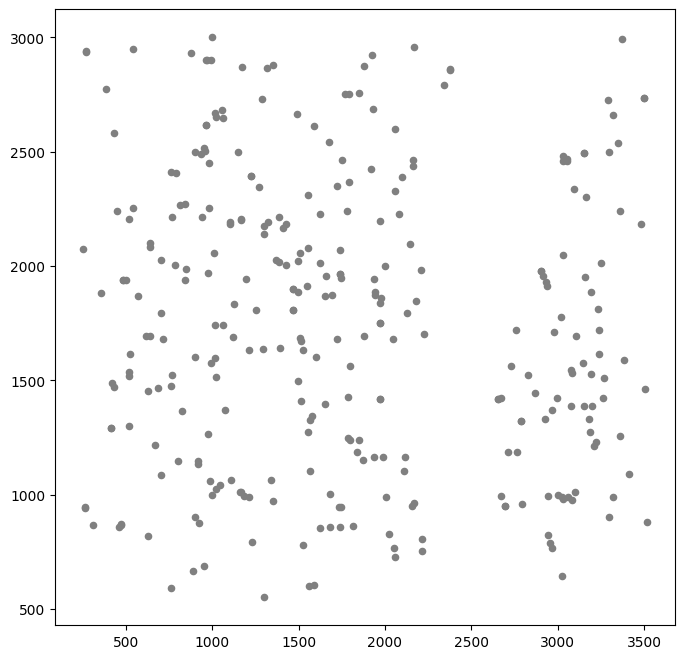

In [56]:
# Plotting Graph (Version 1)
# Displaying the Graph Similar to Inspiration from Nazanin - https://github.com/nazaninmehregan/5P30-Final-Project/blob/master/5P30_Final_Project.ipynb
X = df[['X', 'Y']].values

# create a layout for the graph nodes
pos = dict(zip(range(len(df)), X))

# draw the graph
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(df['X'], df['Y'], s=20, color='grey')
nx.draw_networkx_nodes(G, pos, node_color='r', node_size=20, ax=ax)
nx.draw_networkx_edges(G, pos, edge_color='b', ax=ax)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()


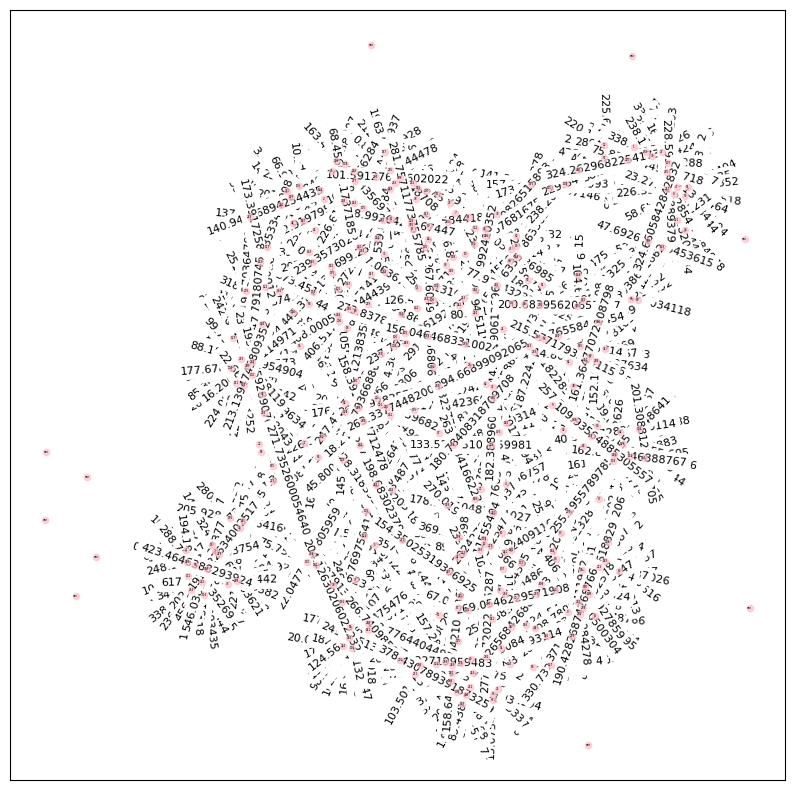

In [59]:
# Plotting Graph (Version 2) - ----> HELP: Generates a circle????
# Displaying the Graph Distance Similar to Inspiration from Nazanin - https://github.com/nazaninmehregan/5P30-Final-Project/blob/master/5P30_Final_Project.ipynb

# generate a layout for the graph nodes
pos = nx.spring_layout(G, k=1.1, iterations=50, seed=42)

fig, ax = plt.subplots(figsize=(10, 10))


# draw the nodes of the graph
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='pink', alpha=0.7, edgecolors='pink')
nx.draw_networkx_labels(G, pos, font_size=2, font_family='sans-serif')

# draw the edges of the graph
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)

# get the edge weights as a dictionary
edge_labels = nx.get_edge_attributes(G, 'weight')

# draw the edge weights as labels
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# display the graph

plt.show()

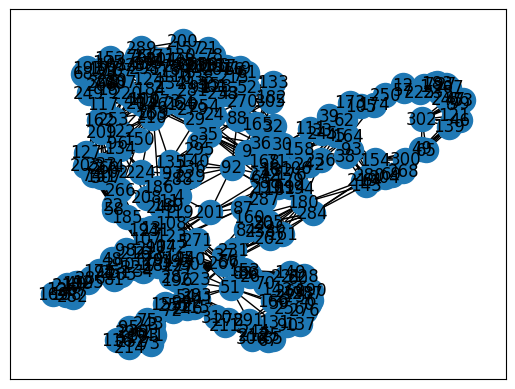

Graph with 311 nodes and 1867 edges


In [50]:
# Plotting Graph (Version 3) - ----> HELP: Generates a circle????
# Displaying the Graph Edges Similar to Inspiration from Nazanin - https://github.com/nazaninmehregan/5P30-Final-Project/blob/master/5P30_Final_Project.ipynb

# specify node positions
pos = nx.spring_layout(G,k=1, iterations=50, seed=42) 

# draw nodes
nx.draw_networkx_nodes(G, pos) 

# draw node labels
nx.draw_networkx_labels(G, pos)

# draw edges
nx.draw_networkx_edges(G, pos)  


plt.show() 

print(G)

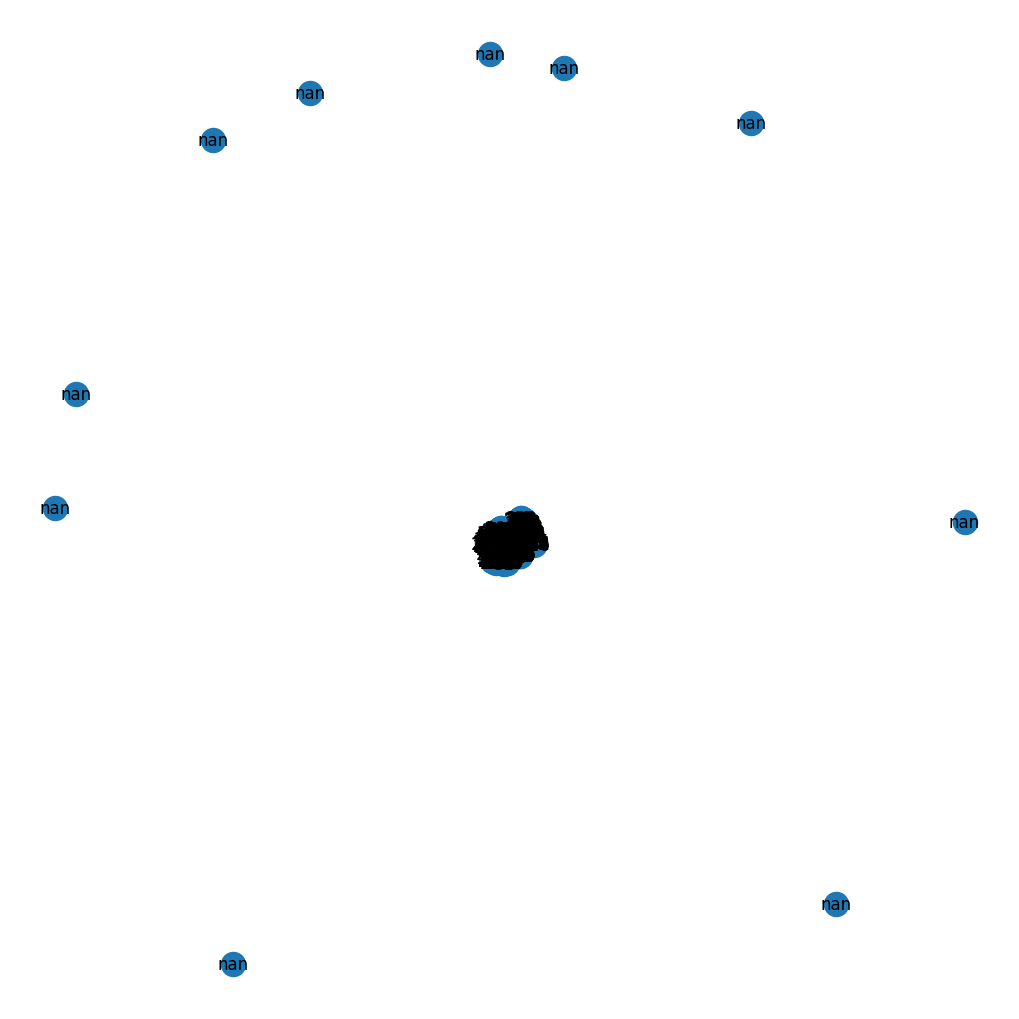

In [51]:


# My Interpretation below ---> Work in Progress

data = Data(
    x=torch.tensor(x_list), 
    y=torch.tensor(y_list), 
    edge_index=torch.tensor(edge).t().contiguous()
    )

G.add_nodes_from(vertex.numpy())
G.add_edges_from(edge)

# -------------------------------------------------------GRAPH CUSTOMIZATION

# Increase the size of the figure
ax = plt.figure(figsize=(10, 10))

# -------------------------------------------------------GRAPH CUSTOMIZATION


# Visualize the graph
pos = nx.spring_layout(G)  # Define the layout of the graph
nx.draw(G, pos, with_labels=True)


plt.savefig('graph.png')



# Convert the graph to an adjacency matrix
adj_matrix = nx.convert_matrix.to_numpy_array(G)

# Save the adjacency matrix to a file
np.savetxt('adjacency_matrix.csv', adj_matrix, delimiter=',')


# Apply feature normalization
transform = NormalizeFeatures()
data = transform(data)




## CONVERT Dataset

Convert Dataset to same format as Planetoid - https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_dataset.html

In [ ]:
## missing get_item function, 
class MyDataset(InMemoryDataset):
    #root = root directory where the data is stored. The directory should further contain two sub-directory "raw_dir" and "processed_dir".
    #the data should be put into the "raw_dir"
    def __init__(self, root, file_name, transform=None, pre_transform=None):
        # print('Step 3 INIT')
        self.filename = file_name
      

        # Save the DataFrame to a CSV file
        # print('4 - DataFrame ')
        self.path = os.path.join(root, file_name)
        data = pd.read_csv(self.path)
        data.to_csv(self.path, index=False)

        super(MyDataset, self).__init__(root, transform, pre_transform)
        # print('NEXT')

    @property
    def processed_dir(self):
        # Create the processed directory if it doesn't exist
        if not os.path.exists(processed_dir):
            os.makedirs(processed_dir)
            # Create the processed directory if it doesn't exist
            os.makedirs(self.processed_dir, exist_ok=True)
        return os.path.join('/', 'processed')

    @property
    def raw_file_names(self):
        # Specify the name of your raw CSV file 
        # print('5 - Raw')
        directory = './data/raw'
        if not os.path.exists(directory):
            os.makedirs(directory)

        return [self.filename]

    @property
    def processed_file_names(self):
        # print('6 - Processed')
        # Specify the name of your processed file (e.g., serialized PyTorch object)
        # if self.test:
        #    return [f'data_test_{i}.pt' for i in range(len(self.data))]
        # else:
        #     return [f'data_{i}.pt' for i in range(len(self.data))]
        directory = './data/processed'
        if not os.path.exists(directory):
            os.makedirs(directory)



        return ['data.pt']
    
    def download(self):
        # print('5 - Download')
        self.path = os.path.join(root, file_name)
        # print(path)
        self.data = pd.read_csv(self.path)

        # Save the DataFrame to a CSV file
        self.data.to_csv(self.path, index=False)
        # print('5 - Download - END')

      
    def __getitem__(self, index):
        # Load the processed data from disk
        self.data = torch.load(self.processed_paths[0])
        
        # Return the data sample at the specified index
        return self.data

    def process(self):
        # Read the CSV file using pandas  
        # print('7 - Process Data')
        # print(data)

        # Perform necessary preprocessing, feature extraction, etc., on the data
        # You need to transform your data into the appropriate format for PyTorch Geometric
        edge_index = []
        x_list = []
        y_list = []

        # Calculate the number of features based on the processed data
        num_features = len(x_list[0])  # Assuming all samples have the same number of features
    
        self.data.num_features = num_features

        # print("Data Frame")
        # print(self.data)

        # Convert 'Car ID' column to numeric values
        self.data['Car ID'] = pd.to_numeric(self.data['Car ID'], errors='coerce')

        # Assign numeric IDs based on 'Car ID' column
        car_ids = torch.tensor(self.data['Car ID'].values, dtype=torch.float)
        vertex = car_ids  # Use 'Car ID' as the vertex tensor


       # Loop row by row
        for index, row in self.data.iterrows():
            # print('>>', self.data.loc[index, 'Car ID'],'\n')
            # print('>>')

            x1 = self.data.loc[index, 'X']
            y1 = self.data.loc[index, 'Y']

            # Inner loop to iterate through all other vehicles
            for inner_index, inner_row in self.data.iterrows(): ## ----> Problem resolved here (need to add above and also add below graph output code to ensure it does not show data in a donut formation)
               if index == len(self.data) - 1:
                   break  # exit for loop
 
               x2 = self.data.loc[inner_index, 'X']
               y2 = self.data.loc[inner_index, 'Y']

               distance = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
               # print(distance)

               # Convert the dataframe to the edge index matrix
               if distance <= 100: # This will include self references
                   #print(data.loc[inner_index,'Car ID'], end=' ')
                   new_edge = (index, inner_index)
                   edge_index.append(new_edge)
                   x_list.append(x1)
                   y_list.append(y1)

        # Create PyTorch Geometric Data object
        self.data = Data(
            x=torch.tensor(x_list),  # Replace with your actual node features
            y=torch.tensor(y_list),  # Replace with your actual node labels (if any)
            edge_index=torch.tensor(edge_index).t().contiguous()  # Replace with your actual edge index
       )

        # Set the num_features attribute
        self.num_features = self.data.x.shape[1]

        torch.save(self.data, os.path.join(self.processed_dir, self.processed_paths[0]))
       # torch.save(df, self.processed_paths[0])
        
      
# Define the root directory where the dataset will be stored
# print('1 - Setup')
root = './'
file_name = 'May 4th Dataset Car and Tower  - Sheet1.csv'

dest = os.path.join(root, file_name)

## Display the files under root path
# contents = os.listdir(root+"/")

# # Print the contents
# for item in contents:
#     print(item)


##### KEEP FOR FUTURE UPLOADS
# from google.colab import files 
# uploaded = files.upload()
# file_name = next(iter(uploaded))
##### KEEP FOR FUTURE UPLOADS


# Create an instance of your dataset
# print('Step 2 - Call My DataSet Class')
dataset = MyDataset(root,file_name)
###dataset.process() ---> YOU DO NOT NEED TO CALL IT. IT IS AUTOMATICALLY TRIGGED



# Access the dataset using the `dataset` variable
# For example, you can access the first graph's node features and labels as follows:
# print('Step 8 - Graph Output')
# x = data['x']
# y = data['y']
# edge_index = data['edge_index']

# ### Display the graph here 
# # Convert the PyTorch Geometric data to a NetworkX graph
# G = nx.Graph()
# if i in data:
#         G.add_node(i, pos=(x[i].item(), y[i].item()))
# G.add_edges_from(edge_index.t().tolist())

# # Plot the graph based on x and y coordinates
# pos = nx.get_node_attributes(G, 'pos')
# plt.figure(figsize=(10, 10))
# nx.draw(G, pos, with_labels=True)
# plt.show()

## Graph AutoEncoder GAE

Graph AutoEncoders GAE &  
Variational Graph Autoencoders VGAE    

[Tutorial 6 paper](https://arxiv.org/pdf/1611.07308.pdf)  
[Tutorial 6 code](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/autoencoder.py)

### Load the data

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = T.Compose([
    T.NormalizeFeatures(),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      split_labels=True, add_negative_train_samples=True),
    T.ToDevice(device)])

# My Dataset code
dataset = MyDataset(root, file_name, transform)
train_data, val_data, test_data = dataset[0]


### Define the Encoder

In [ ]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True) # cached only for transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)
    

### Define the Autoencoder

In [ ]:
from torch_geometric.nn import GAE

In [ ]:
# parameters
out_channels = 2
num_features = data.num_features #### RESUME - May 18th
epochs = 100

# model
model = GAE(GCNEncoder(num_features, out_channels))

# move to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
positive_edge_index = data.train_pos_edge_index.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
def train():
    model.train()
    print('1')
    optimizer.zero_grad()
    print('2')
    z = model.encode(x, train_pos_edge_index)
    print('3')
    loss = model.recon_loss(z, train_pos_edge_index)
    print('4')
    if args.variational:
      print('5')
      loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    print('6')
    optimizer.step()
    print('7')
    return float(loss)


def test(pos_edge_index, neg_edge_index):
    model.eval()
    print('8')
    with torch.no_grad():
        print('9')
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)



In [ ]:
for epoch in range(1, epochs + 1):
    loss = train()

    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

In [ ]:
Z = model.encode(x, train_pos_edge_index)
Z

## Are the results (AUC) and (AP) easy to read and compare?

# Use Tensorboard

In [ ]:
from torch.utils.tensorboard import SummaryWriter

In [ ]:
# parameters
out_channels = 2
num_features = dataset.num_features
epochs = 100

# model
model = GAE(GCNEncoder(num_features, out_channels))

# move to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

### Import tensorboard

#### Installation: (if needed) "pip install tensorboard"

In [ ]:
writer = SummaryWriter('runs/GAE1_experiment_'+'2d_100_epochs')

In [ ]:
for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    
    
    writer.add_scalar('auc train',auc,epoch) # new line
    writer.add_scalar('ap train',ap,epoch)   # new line

## Graph Variational AutoEncoder (GVAE)

In [ ]:
from torch_geometric.nn import VGAE
!pip install --verbose torch-scatter

In [ ]:
dataset = Planetoid("\..", "CiteSeer", transform=T.NormalizeFeatures())
data = dataset[0]
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = train_test_split_edges(data)


class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VariationalGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [ ]:
out_channels = 2
num_features = dataset.num_features
epochs = 300


model = VGAE(VariationalGCNEncoder(num_features, out_channels))  # new line

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    
    loss = loss + (1 / data.num_nodes) * model.kl_loss()  # new line
    loss.backward()
    optimizer.step()
    return float(loss)


def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [ ]:
writer = SummaryWriter('runs/VGAE_experiment_'+'2d_100_epochs')

for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    
    
    writer.add_scalar('auc train',auc,epoch) # new line
    writer.add_scalar('ap train',ap,epoch)   # new line